In [60]:
# pip install kagglehub[pandas-datasets]
# install the above by removing the hash symbol first to run this notebook

In [61]:
import kagglehub # This is imported to laod the dataset directly from kaggle instead of downloading it directly
from kagglehub import KaggleDatasetAdapter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # this and seaborn together are used in plotting the various distributions within the notebook
import seaborn as sns
import math
from sklearn.model_selection import train_test_split # this is added to ensure that the test subset of our dataset is isolated when training the model
from sklearn.metrics import classification_report, ConfusionMatrixDisplay # These are various metrics for visualizing the model performance
from sklearn.ensemble import RandomForestClassifier # this is the random forest ensemble model
from sklearn.naive_bayes import MultinomialNB, GaussianNB # these are the naive bayes classifiers depending on the feature assumptions
from sklearn.preprocessing import OneHotEncoder # this is used to encode the categorical features into machine readble numerics
from sklearn.compose import  make_column_selector as selector, ColumnTransformer # necessary for mooel preprocessing
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as Pipeline
from imblearn.over_sampling import SMOTE # this is used to overcome dataset imbalance of the training set
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif # this is added to improve accuracy of the model




In [62]:
file_path = "adult.csv"
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "mosapabdelghany/adult-income-prediction-dataset",
  file_path,
)
#df = pd.read_csv('/Users/E1012131/Downloads/adult.csv')
df.replace('?', np.nan, inplace=True) # this changes all question marks within the features to NaN null values
df = df.dropna()  # Drop rows with missing values

print(df.describe()) # gves a description of the dataframe we are working with
print(df.columns) # lists out all feature column names

                age        fnlwgt  education.num  capital.gain  capital.loss  \
count  30162.000000  3.016200e+04   30162.000000  30162.000000  30162.000000   
mean      38.437902  1.897938e+05      10.121312   1092.007858     88.372489   
std       13.134665  1.056530e+05       2.549995   7406.346497    404.298370   
min       17.000000  1.376900e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.176272e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.784250e+05      10.000000      0.000000      0.000000   
75%       47.000000  2.376285e+05      13.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours.per.week  
count    30162.000000  
mean        40.931238  
std         11.979984  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  
Index(['age', 'workclass', 'fnlwgt', 'education', 'education.nu

In [63]:
X = df.drop(['income'], axis=1) # Features
y = df['income'].str.strip()  # target ...trimmed

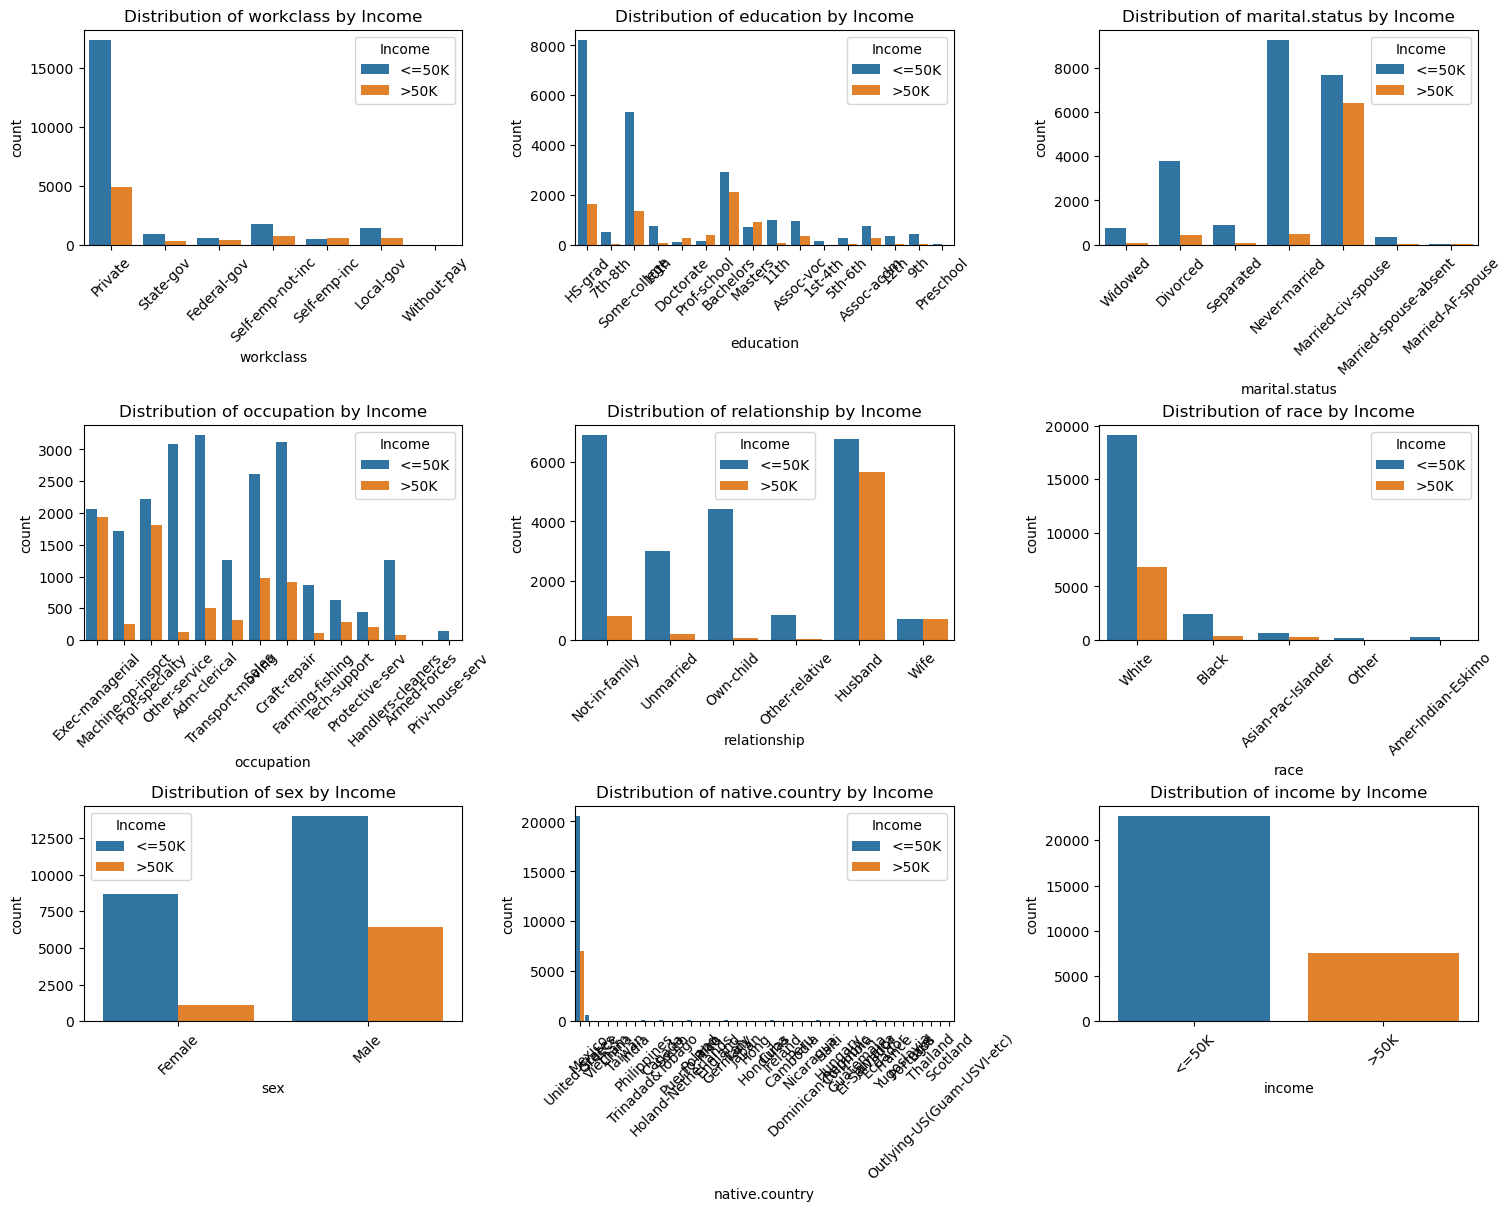

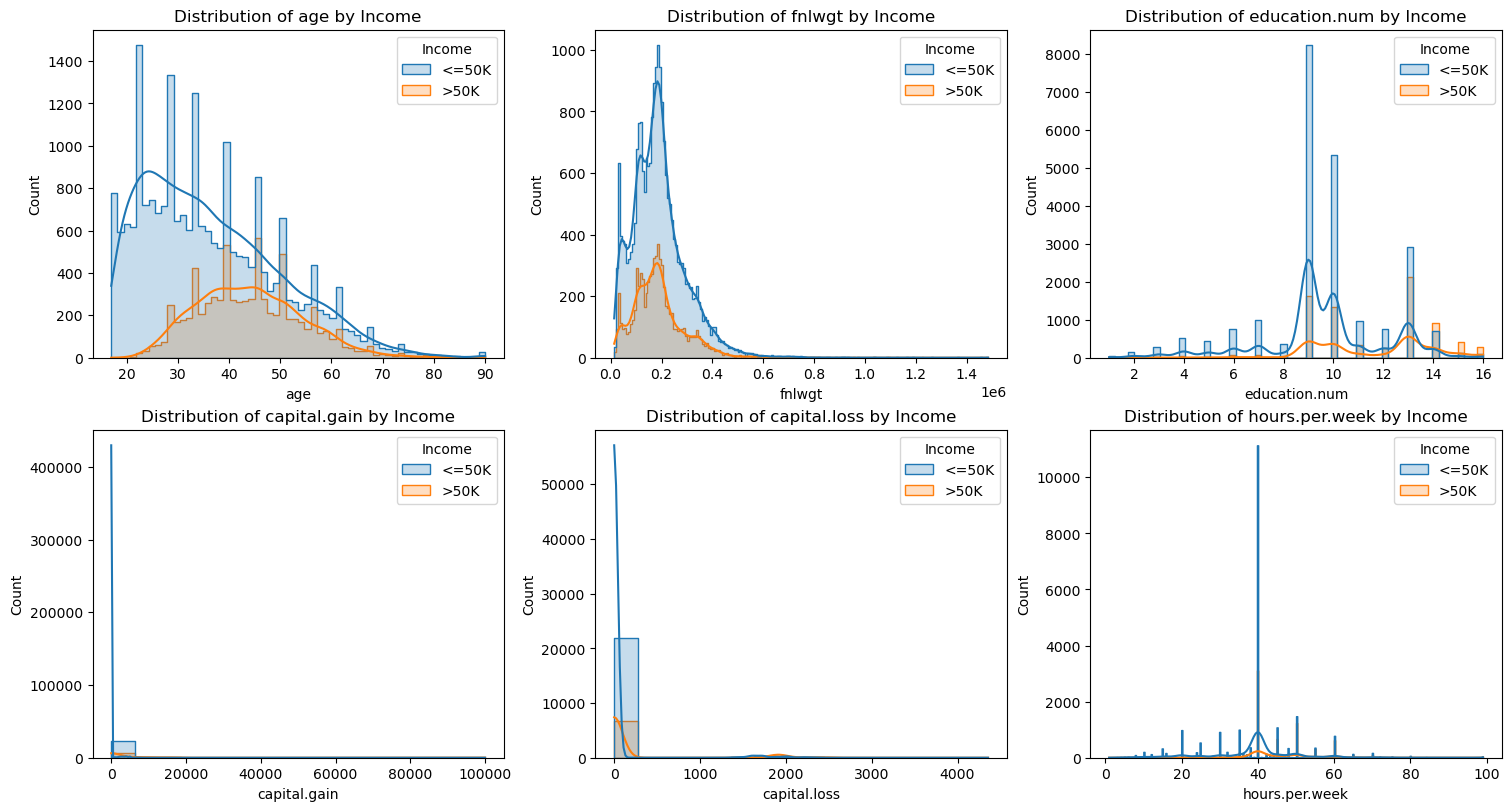

In [64]:
# data visualization
   #df= X.copy()
df['Income'] = y

numeric_features = selector(dtype_include=['int64', 'float64']) # selecting which of the features are numeric
categorical_features = selector(dtype_include=['object', 'category']) # selecting which of the features re categorical

cat_feats = categorical_features(df.drop(columns=['Income'])) # selecting vategorical features from X dataframe
num_feats = numeric_features(df.drop(columns=['Income'])) # selecting numerical features from X dataframe

# --- Categorical in one figure ---
n_cat = len(cat_feats) # length of categorical features
cols_cat = 3
rows_cat = math.ceil(n_cat / cols_cat)

fig_cat, axes_cat = plt.subplots(rows_cat, cols_cat, figsize=(cols_cat * 5, rows_cat * 4), constrained_layout=True) # Here we are plotting multiple plots at together thats why we need the plt.subplots
axes_cat = axes_cat.flatten()

for i, col in enumerate(cat_feats): # we are plotting a graph for every categorical feature
    ax = axes_cat[i]
    sns.countplot(data=df, x=col, hue='Income', ax=ax)
    ax.set_title(f'Distribution of {col} by Income')
    ax.tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes_cat)):
    axes_cat[j].set_visible(False)

plt.show() # this shows the sum-plot

# --- Numeric in one figure ---
n_num = len(num_feats) # the following is similar to the above but for the numerical features
cols_num = 3
rows_num = math.ceil(n_num / cols_num)

fig_num, axes_num = plt.subplots(rows_num, cols_num, figsize=(cols_num * 5, rows_num * 4), constrained_layout=True)
axes_num = axes_num.flatten()

for i, col in enumerate(num_feats):
    ax = axes_num[i]
    sns.histplot(data=df, x=col, hue='Income', kde=True, element="step", ax=ax)
    ax.set_title(f'Distribution of {col} by Income')

for j in range(i + 1, len(axes_num)):
    axes_num[j].set_visible(False)

plt.show()

# the essence of the plots is to see the class distribution of each feature

In [65]:
# split df into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(df['Income'].value_counts()) # this shows the balance of the target. Here it is inbalanced so we account for that when building and preprocessing the model.


Income
<=50K    22654
>50K      7508
Name: count, dtype: int64


In [66]:
# dropping redundant features from X_train
def drop_high_corr_numeric(X, threshold=0.95): # this is a custom function to calculate the correlation between features 
    Xn = X.select_dtypes(include=np.number).copy()
    corr = Xn.corr().abs()
    upper = np.triu(np.ones(corr.shape), k=1).astype(bool)
    upper_corr = corr.where(upper)
    to_drop = [col for col in upper_corr.columns if any(upper_corr[col] >= threshold)]

    # Return list of columns to keep (drop only numeric duplicates; keep categoricals)
    keep_cols = [c for c in X.columns if c not in to_drop]
    return keep_cols, to_drop

keep_cols, dropped_cols = drop_high_corr_numeric(X_train, threshold=0.95) # features with high correlation are dumped as feature selection
print("Dropped (numeric) due to high correlation:", dropped_cols) # show the features dropped

# Filter training and test consistently
X_train = X_train[keep_cols].copy() # features kept are used as training and test columns
X_test = X_test[keep_cols].copy()


Dropped (numeric) due to high correlation: []


<module 'matplotlib.pyplot' from 'c:\\Users\\E1012131\\AppData\\Local\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

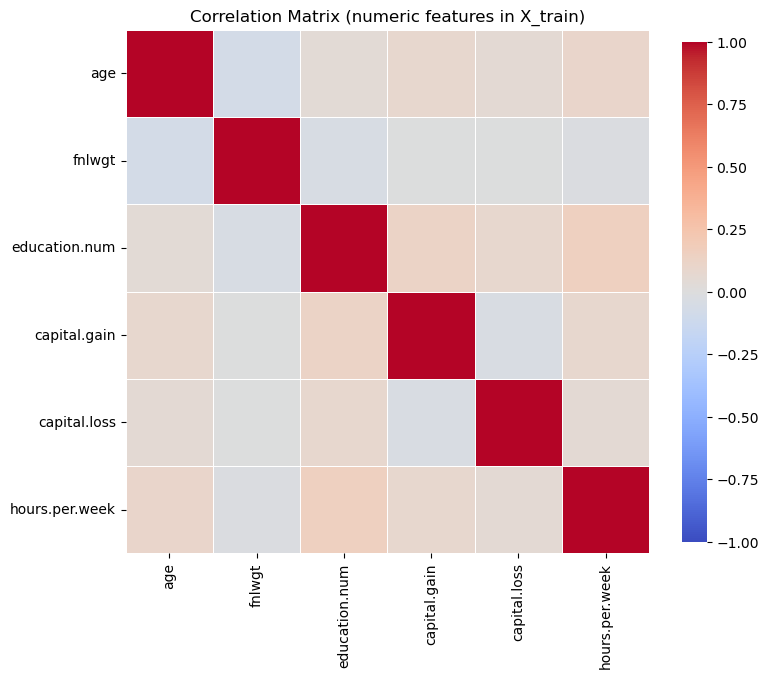

In [67]:
# this is based on pearson correlation observations for numeric features
Xn = X_train.select_dtypes(include=np.number)
corr = Xn.corr()  # Pearson correlation by default

plt.figure(figsize=(8, 8))
sns.heatmap(
    corr,
    cmap='coolwarm',
    vmin=-1, vmax=1, center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.7}
)
plt.title('Correlation Matrix (numeric features in X_train)')
plt.tight_layout()
plt


In [68]:
# dropping other redundant features based on EDA observations
redundant_features = ['race', 'native.country', 'fnlwgt']
X_train = X_train.drop(columns=redundant_features)
X_test = X_test.drop(columns=redundant_features)


Training and evaluating model: Random Forest
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.91      0.86      0.88      4531
        >50K       0.64      0.73      0.68      1502

    accuracy                           0.83      6033
   macro avg       0.77      0.80      0.78      6033
weighted avg       0.84      0.83      0.83      6033



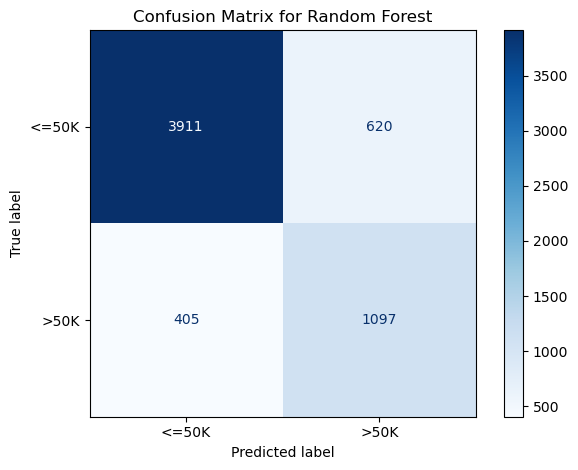


Training and evaluating model: Multinomial NB
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.79      0.96      0.87      4531
        >50K       0.64      0.21      0.32      1502

    accuracy                           0.77      6033
   macro avg       0.72      0.59      0.59      6033
weighted avg       0.75      0.77      0.73      6033



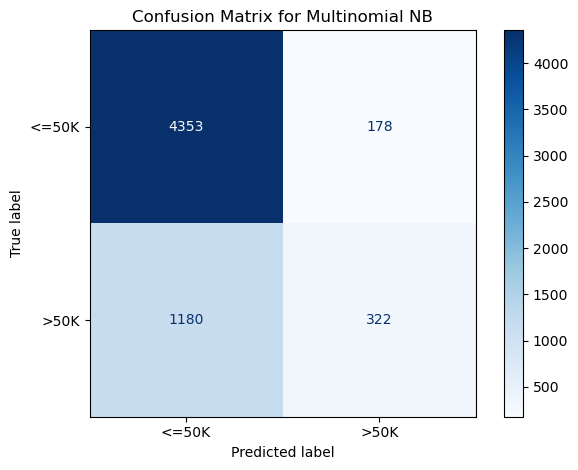


Training and evaluating model: GaussianNB
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.90      0.86      0.88      4531
        >50K       0.63      0.71      0.67      1502

    accuracy                           0.82      6033
   macro avg       0.76      0.79      0.77      6033
weighted avg       0.83      0.82      0.83      6033



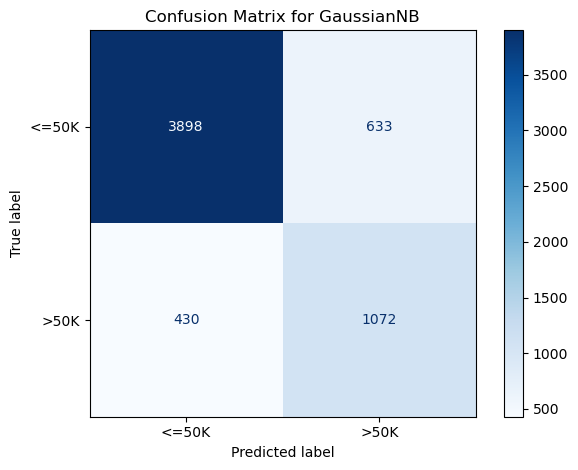

In [69]:
def training_class(): # this is a function to call multiüle models within a pipeline to avoid data leakage between training and test subsets
    # Define models
    models = {
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
        'Multinomial NB': MultinomialNB(),
        'GaussianNB': GaussianNB()   
    }

    # Preprocessing pipelines
    numeric_pipe = SkPipeline([
        ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
       #('scaler', StandardScaler()) # here scaling is rempved as the models do not require it
    ])
    categorical_pipe = SkPipeline([
        ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # this encoding method is selected as it is suitable for the naive bayes classifiers its irrelevant for the random forest
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipe, numeric_features),
            ('cat', categorical_pipe, categorical_features),
        ]
    )

    for model_name, model in models.items(): # for every model in the initialized model dicitonary 
        print(f"\nTraining and evaluating model: {model_name}")
                
        # Build pipeline per model
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('kbest', SelectKBest(score_func=mutual_info_classif, k=15)), #''' the k values could range from 5 to 62 . 24 was chosen based on multiple runs of the model. This is used to select features based on mutual information which is suitable for both categorical and numerical features. This is the feature-target relationship. '''
            ('smote', SMOTE(random_state=42, sampling_strategy=0.5, k_neighbors=5)), # this controls the variablity of synthetic samples used in reducing oversamling. 42 is a fixed value to ensure the model generates the same synthetic samples each time it is run
            ('classifier', model)
        ]) # the preprocessors, oversampling(smote) as well as model type are ladaed for each model in a pipe

        # Fit & predict
        pipe.fit(X_train, y_train) # the pipe for each model is then fitted based on the training dataset
        y_pred = pipe.predict(X_test) # here we mkae predicitons using the X_test subset on the fitted pipe model

        # Metrics
        print("Classification Report:")
        print(classification_report(y_test, y_pred)) # This shows the metrics of the relevant model which is then used to measure performance
        
        # Confusion Matrix plot)
        disp = ConfusionMatrixDisplay.from_estimator(
            pipe, X_test, y_test, cmap=plt.cm.Blues, normalize=None
        )
        disp.ax_.set_title(f'Confusion Matrix for {model_name}') # shows the matric of true, false , negativaes and postives of the model. The diagonal from left-top to bottom-right is the true positive
        plt.tight_layout()
        plt.show()
            
training_class() # the function is run so the multiple models are generated and tested one after the other

Based on this model results, for our dataset which comprises of numerical an categorical features the random forest outperforms the naive bayes models.